# Example 2: UQ of a CFD problem with two input parameters

In [19]:
from equadratures import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")

#%matplotlib notebook

## 1. Defining our parameters

Again, we don't have any prior knowledge of what $\hat{\nu}/\nu$ should be, except for that it lies in the range 1 to 100, so lets set it as a uniform distribution.

In [20]:
# Define nut/nu as a parameter called s1
s1 = Parameter(distribution='uniform', lower=1.0, upper=100, order=3) #turb2lamviscosity
print(s1.get_description())

is a uniform distribution over the support 1.0 to 100.


For $Ti$ we know it is somewhere around $Ti \approx 10\%$, but don't have much confidence in this. Therefore lets define it as a Gaussian with mean=10 and variance=5.  

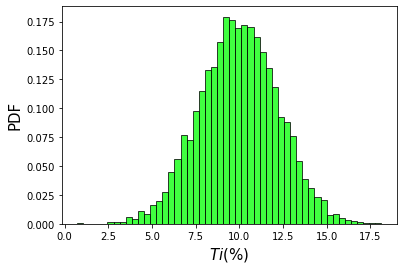

is a Gaussian distribution with a mean of 10 and a variance of 5.


In [21]:
# Define Ti as a parameter called s2, with a Gaussian distribution. 
# You'll need the args shape_parameter_A and shape_parameter_B.
s2 = Parameter(distribution='Gaussian', shape_parameter_A=10, shape_parameter_B=5, order=3) #Ti

# PDF of s2 is plotted here
z2_samples = s2.get_samples(9000)
n, bins, patches = plt.hist(z2_samples, 50, density=True, facecolor='lime', alpha=0.75, edgecolor='k')
plt.xlabel(r'$Ti (\%)$', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.show()
print(s2.get_description())

## 2. Defining a basis

This is now a multivariate problem so we shall use the ``tensor-grid`` basis instead of the ``univariate`` used previously. 

In [22]:
# Define a Basis object
mybasis = Basis('tensor-grid', orders=[s1.order, s2.order])

## 3. Defining a polynomial and getting DOE points

As in example 1 and 2, we need to define a Poly object and get the DOE points. 

Notice how now we have 16 CFD evaluations to do instead of 4. 

In [23]:
# Define a Poly object
mypoly = Poly(parameters=[s1,s2], basis=mybasis, method='numerical-integration')

# Get the DOE points
pts = mypoly.get_points()

# Print and save to file
print('SA ratio \t Ti')
print(pts)
np.save('points_to_run.npy', pts)

SA ratio 	 Ti
[[ 7.87375258  4.78009112]
 [ 7.87375258  8.34091854]
 [ 7.87375258 11.65908146]
 [ 7.87375258 15.21990888]
 [33.67093834  4.78009112]
 [33.67093834  8.34091854]
 [33.67093834 11.65908146]
 [33.67093834 15.21990888]
 [67.32906166  4.78009112]
 [67.32906166  8.34091854]
 [67.32906166 11.65908146]
 [67.32906166 15.21990888]
 [93.12624742  4.78009112]
 [93.12624742  8.34091854]
 [93.12624742 11.65908146]
 [93.12624742 15.21990888]]


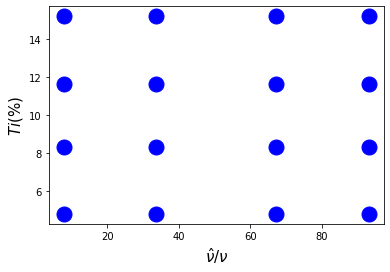

In [24]:
# Plot the DOE points
plt.plot(pts[:,0], pts[:,1], 'bo', markersize=15)
plt.xlabel(r'$\hat{\nu}/\nu$', fontsize=15)
plt.ylabel(r'$Ti (\%)$', fontsize=15)
plt.show()

## 4. Finding the polynomial coefficients

In [25]:
# Load the Yp array from file
Yp = np.load('lossarray_sst.npy').reshape(-1, 1)

# Print the Yp array
print('SA ratio \t Ti \t\t Y_p')
print(np.hstack([pts,Yp]))

SA ratio 	 Ti 		 Y_p
[[7.87375258e+00 4.78009112e+00 5.30310580e-02]
 [7.87375258e+00 8.34091854e+00 5.28644236e-02]
 [7.87375258e+00 1.16590815e+01 5.26925252e-02]
 [7.87375258e+00 1.52199089e+01 5.24967211e-02]
 [3.36709383e+01 4.78009112e+00 5.32419115e-02]
 [3.36709383e+01 8.34091854e+00 5.32333854e-02]
 [3.36709383e+01 1.16590815e+01 5.30672169e-02]
 [3.36709383e+01 1.52199089e+01 5.28340593e-02]
 [6.73290617e+01 4.78009112e+00 5.32581624e-02]
 [6.73290617e+01 8.34091854e+00 5.33894321e-02]
 [6.73290617e+01 1.16590815e+01 5.32981622e-02]
 [6.73290617e+01 1.52199089e+01 5.30067064e-02]
 [9.31262474e+01 4.78009112e+00 5.32606790e-02]
 [9.31262474e+01 8.34091854e+00 5.34980151e-02]
 [9.31262474e+01 1.16590815e+01 5.34417742e-02]
 [9.31262474e+01 1.52199089e+01 5.32224419e-02]]


Pass the model evaluations back to ``mypoly`` with ``set_model()``.

In [26]:
mypoly.set_model(Yp)

## 5. Computing the moments

In [9]:
mean, var = mypoly.get_mean_and_variance()
print(mean, var)

0.053190749833244844 5.714480753272688e-08


## 6. Dealing with invalid samples

Now, what happens if some of the CFD values are NaNs? To simulate this, we simply pick a few random entries of the ``Yp`` array and set them to be NaN.

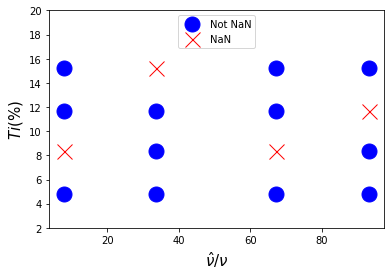

In [61]:
# Enter list of points you want to set to NaN here (0 to 15)
indices = [1,7,9,14]
indices_to_set_to_NaN = np.asarray(indices)

# Set chosen points to NaN
Yp_with_NaNs = deepcopy(Yp)
Yp_with_NaNs[indices_to_set_to_NaN] = np.nan * indices_to_set_to_NaN.reshape(len(indices_to_set_to_NaN),1)

# Plot the DOE points
NaN = np.isnan(Yp_with_NaNs).flatten()
plt.plot(pts[~NaN,0], pts[~NaN,1], 'bo', markersize=15,label='Not NaN')
plt.plot(pts[NaN,0], pts[NaN,1], 'rx', markersize=15,label='NaN')
plt.xlabel(r'$\hat{\nu}/\nu$', fontsize=15)
plt.ylabel(r'$Ti (\%)$', fontsize=15)
plt.legend(loc='upper center')
plt.ylim([2,20])
plt.show()

Now pass the ``Yp_with_NaNs`` array to ``mypoly`` with ``set_model()``.

In [12]:
mypoly.set_model(Yp_with_NaNs)

The code will now use a least-squares technique that will ignore input-output pairs of your model that have NaNs. This will likely compromise computed statistics.


Lets compute the moments and see how accurate they are compared to the case without NaNs.

In [13]:
# Compute moments
mean_with_NaNs, var_with_NaNs = mypoly.get_mean_and_variance()

# Print
print('Original  mean = %.5f, Original  variance = %.3e' %(mean,var))
print('With NaNs mean = %.5f, With NaNs variance = %.3e' %(mean_with_NaNs,var_with_NaNs))
err_mean = 100.*(mean_with_NaNs-mean)/mean
err_var  = 100.*(var_with_NaNs -var) /var
print('Errors: mean = %.2f%%, variance = %.2f%%' %(err_mean,err_var))

Original  mean = 0.05319, Original  variance = 5.714e-08
With NaNs mean = 0.05321, With NaNs variance = 5.930e-08
Errors: mean = 0.03%, variance = 3.77%
